In [5]:
import pandas as pd
import numpy as np
import io
import sys
import os.path
import urllib.request
from tqdm import tqdm
from os import listdir
from PIL import Image
import glob
import pytesseract
# Link para descargar el ejecutable de tesseract: https://github.com/UB-Mannheim/tesseract/wiki
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
from Levenshtein import distance as lev
import cv2      # pip install opencv-python
import matplotlib.pyplot as plt


pd.set_option('display.max_colwidth', -1)
np.set_printoptions(threshold=sys.maxsize)

C:\Users\javie\AppData\Local\Temp\ipykernel_20588\1203669978.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [6]:
df = pd.read_csv("MovieGenre.csv",encoding='ISO-8859-1')
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,"https://images-na.ssl-images-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_UX182_CR0,0,182,268_AL_.jpg"
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,"https://images-na.ssl-images-amazon.com/images/M/MV5BZTk2ZmUwYmEtNTcwZS00YmMyLWFkYjMtNTRmZDA3YWExMjc2XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UY268_CR10,0,182,268_AL_.jpg"
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BMjQxM2YyNjMtZjUxYy00OGYyLTg0MmQtNGE2YzNjYmUyZTY1XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg"
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTczMTMyMTgyM15BMl5BanBnXkFtZTcwOTc4OTQyMQ@@._V1_UY268_CR4,0,182,268_AL_.jpg"
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BOTEyNzg5NjYtNDU4OS00MWYxLWJhMTItYWU4NTkyNDBmM2Y0XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg"


In [7]:
#Remove NaN valued entries
df= df.dropna(how='any')
df = df.tail(200)
df.shape

(200, 6)

In [8]:
#Method 1 to download images
not_found = []
coverIdentifiers = []
for index, row in tqdm(df.iterrows()):
    
    url = row['Poster']
    imdb_id = row['imdbId']
    
    file_path = "Posters/" + str(imdb_id) + ".jpg"
    
    try:
        response = urllib.request.urlopen(url)
        data = response.read()
        file = open(file_path, 'wb')
        file.write(bytearray(data))
        coverIdentifiers.append(str(imdb_id))
        file.close()
    except:
        not_found.append(imdb_id)
        
print("Number of posters not found = ", len(not_found))
print("Following IMDB_ID posters were not found::", not_found)

200it [00:08, 22.85it/s]

Number of posters not found =  7
Following IMDB_ID posters were not found:: [2596918, 491603, 3000844, 54826, 67576, 88757, 83168]


In [9]:
image1 = Image.open('Posters/5957584.jpg') 
imageObj1 = cv2.imread('Posters/815258.jpg')
results = []
for i in coverIdentifiers:
    image2 = Image.open('Posters/'+ i + '.jpg')
    imageObj2 = cv2.imread('Posters/'+ i + '.jpg')

    print(image1.filename)
    print(image2.filename)

    if image2 != image1:

        #Comparison of the strings in the images
        text1 = pytesseract.image_to_string(image1)#get the first text
        text2 = pytesseract.image_to_string(image2)#get the second text

        words1 = tuple(text1.split())
        words2 = tuple(text2.split())

        sum = 0
        for i in range(len(words1)):
            for j in range(len(words2)):
                sum = sum + (lev(words1[i],words2[j]))

        if len(words1) == 0 or len(words2) == 0:
            meanText = 0    
        else:
            meanText = sum/(len(words1)*len(words2))

        #Comparison of the color histograms    
        # Get RGB data from image
        blue_color = cv2.calcHist([imageObj1], [0], None, [256], [0, 256])
        red_color = cv2.calcHist([imageObj1], [1], None, [256], [0, 256])
        green_color = cv2.calcHist([imageObj1], [2], None, [256], [0, 256])

        blue_color2 = cv2.calcHist([imageObj2], [0], None, [256], [0, 256])
        red_color2 = cv2.calcHist([imageObj2], [1], None, [256], [0, 256])
        green_color2 = cv2.calcHist([imageObj2], [2], None, [256], [0, 256])

        corrBlue = cv2.compareHist(blue_color,blue_color2,cv2.HISTCMP_CORREL)
        corrGreen = cv2.compareHist(green_color,green_color2,cv2.HISTCMP_CORREL)
        corrRed = cv2.compareHist(red_color,red_color2,cv2.HISTCMP_CORREL)
        meanCorr = (corrBlue+corrGreen+corrRed)/3

        intBlue = cv2.compareHist(blue_color,blue_color2,cv2.HISTCMP_INTERSECT)
        intGreen = cv2.compareHist(green_color,green_color2,cv2.HISTCMP_INTERSECT)
        intRed = cv2.compareHist(red_color,red_color2,cv2.HISTCMP_INTERSECT)
        meanInt = (intBlue+intGreen+intRed)/3

        #Result to compare the two images
        
        results.append(0.3*meanText+0.5*meanCorr+0.2*meanInt)




Posters/5957584.jpg
Posters/4682562.jpg
Posters/5957584.jpg
Posters/4767340.jpg
Posters/5957584.jpg
Posters/4716560.jpg
Posters/5957584.jpg
Posters/1714202.jpg
Posters/5957584.jpg
Posters/3257610.jpg
Posters/5957584.jpg
Posters/3416386.jpg
Posters/5957584.jpg
Posters/3788510.jpg
Posters/5957584.jpg
Posters/219935.jpg
Posters/5957584.jpg
Posters/5072350.jpg
Posters/5957584.jpg
Posters/5564142.jpg
Posters/5957584.jpg
Posters/4150988.jpg
Posters/5957584.jpg
Posters/3108244.jpg
Posters/5957584.jpg
Posters/5170428.jpg
Posters/5957584.jpg
Posters/2933794.jpg
Posters/5957584.jpg
Posters/4235342.jpg
Posters/5957584.jpg
Posters/1619014.jpg
Posters/5957584.jpg
Posters/447987.jpg
Posters/5957584.jpg
Posters/4434688.jpg
Posters/5957584.jpg
Posters/4364338.jpg
Posters/5957584.jpg
Posters/5231402.jpg
Posters/5957584.jpg
Posters/2235348.jpg
Posters/5957584.jpg
Posters/5026308.jpg
Posters/5957584.jpg
Posters/5084214.jpg
Posters/5957584.jpg
Posters/5673202.jpg
Posters/5957584.jpg
Posters/800318.jpg
Pos

(-0.5, 181.5, 267.5, -0.5)

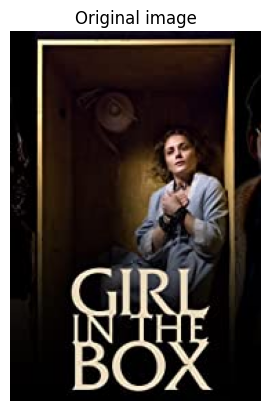

In [10]:
resultsNoOrder = list(zip(results,coverIdentifiers))
resultsOrdered = sorted(resultsNoOrder, reverse = True)


plt.imshow(image1)
plt.title("Original image")
plt.axis("off")

(9755.7, '82875')
(8150.504586244156, '5026308')
(8105.010540995218, '112985')
(8082.840059819951, '5673202')
(7928.115518232893, '4065336')


Text(0.5, 0.98, 'Similar films ranked from more similar (left) to less similar (right)')

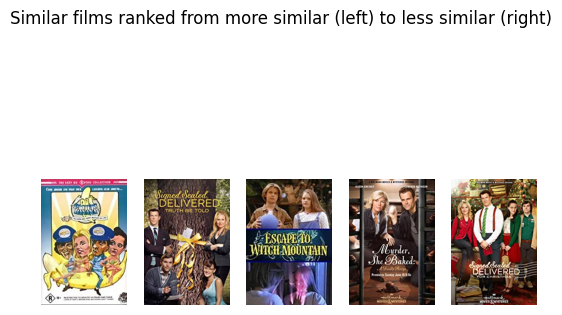

In [11]:
for i in range(5):
    print(resultsOrdered[i])

plt.subplot(1,5,1)
plt.axis("off")
imagetoPlot1 = Image.open("Posters/" + resultsOrdered[0][1] + ".jpg")
plt.imshow(imagetoPlot1)
plt.subplot(1,5,2)
plt.axis("off")
imagetoPlot2 = Image.open("Posters/" + resultsOrdered[1][1] + ".jpg")
plt.imshow(imagetoPlot2)
plt.subplot(1,5,3)
plt.axis("off")
imagetoPlot3 = Image.open("Posters/" + resultsOrdered[2][1] + ".jpg")
plt.imshow(imagetoPlot3)
plt.subplot(1,5,4)
plt.axis("off")
imagetoPlot4 = Image.open("Posters/" + resultsOrdered[3][1] + ".jpg")
plt.imshow(imagetoPlot4)
plt.subplot(1,5,5)
plt.axis("off")
imagetoPlot5 = Image.open("Posters/" + resultsOrdered[4][1] + ".jpg")
plt.imshow(imagetoPlot5)
plt.suptitle("Similar films ranked from more similar (left) to less similar (right)")